In [82]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os 
filtered_metadata_path = os.path.join("..", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join("..", "data", "filtered_clips")


# Load metadata
df = pd.read_csv(filtered_metadata_path, sep='\t')
# Drop unnecessary columns
df.drop(columns=['client_id', 'sentence', 'age', 'gender', 'accent'], inplace=True, errors='ignore')
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,path,up_votes,down_votes,label
0,common_voice_en_19687170.mp3,2,1,3
1,common_voice_en_19687171.mp3,2,1,3
2,common_voice_en_19687172.mp3,2,0,3
3,common_voice_en_19687173.mp3,2,0,3
4,common_voice_en_19687174.mp3,2,0,3


In [83]:
import librosa
from tqdm import tqdm

samples = 200 # df['label'].value_counts().min()
balanced_samples = pd.DataFrame()
for cls in range(4):
    cls_df = df[df['label'] == cls]
    sampled = cls_df.sample(n=samples, random_state=42)  # Random sampling
    balanced_samples = pd.concat([balanced_samples, sampled])

def load_audio_file(file_path):
    try:
        return librosa.load(file_path)
    except Exception as e:
        return None, None

X, Y = [], []
error = 0
for row in tqdm(balanced_samples.itertuples(), desc="Loading audio files"):
    audio, sr = load_audio_file(os.path.join(audio_dir, row.path))
    if audio is None:
        error += 1
    else:
        X.append(audio)
        Y.append(row.label)

Loading audio files: 14it [00:00, 137.78it/s]C:\Users\mahmo\AppData\Local\Temp\ipykernel_15172\744861655.py:13: UserWarning:

PySoundFile failed. Trying audioread instead.

c:\Users\mahmo\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Loading audio files: 800it [00:05, 148.44it/s]


In [84]:
from mfcc import MFCC

mfcc = MFCC()
features = mfcc.transform(X)

Extracting MFCCs: 100%|██████████| 768/768 [00:06<00:00, 113.29it/s]


In [85]:
pitch_features = []
for audio in tqdm(X, desc="Extracting pitch features"):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=22050)
    pitch_features.append(pitches.mean(axis=1))  # Example: taking the mean pitch per frame

pitch_features = np.array(pitch_features)

Extracting pitch features: 100%|██████████| 768/768 [00:07<00:00, 103.45it/s]


In [86]:
print(pitch_features.shape)

(768, 1025)


In [87]:
import numpy as np
np.all([len(features[i]) == len(features[i+1]) for i in range(len(features)-1)])

True

In [88]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np

qda = QuadraticDiscriminantAnalysis()
qda.fit(features, Y)
lda_score = qda.score(features, Y)
print(f'LDA Score: {lda_score}')

LDA Score: 0.90625


In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=len(np.unique(Y)), random_state=42)
y_pred = kmeans.fit_predict(features)

# Evaluate how well the clusters match true labels
ari = adjusted_rand_score(Y, y_pred)
print(f'Adjusted Rand Index (ARI): {ari}')


Adjusted Rand Index (ARI): -0.0007347707790676571


In [90]:
import numpy as np

def class_separability_index(X, y):
    # Calculate class means
    class_means = [X[y == c].mean(axis=0) for c in np.unique(y)]
    overall_mean = X.mean(axis=0)
    
    # Between-class scatter
    bss = np.sum([np.sum((mean - overall_mean)**2) for mean in class_means])

    # Within-class scatter
    wss = np.sum([np.sum((X[y == c] - mean)**2) for c, mean in zip(np.unique(y), class_means)])
    
    # Separability index (higher is better)
    return bss / wss

separability_index = class_separability_index(features, Y)
print(f'Separability Index: {separability_index}')


Separability Index: 6.048268187441863e-05


c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



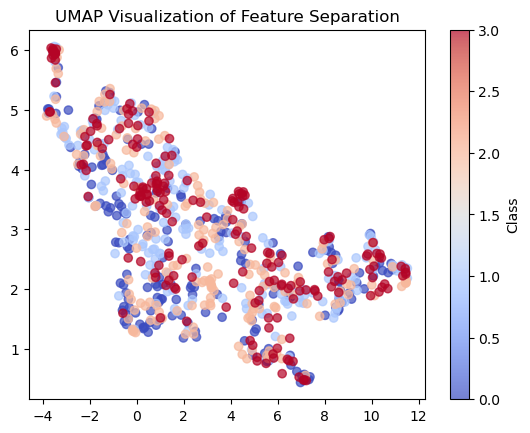

In [91]:
import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_components=2)
X_reduced = umap_model.fit_transform(features)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('UMAP Visualization of Feature Separation')
plt.show()


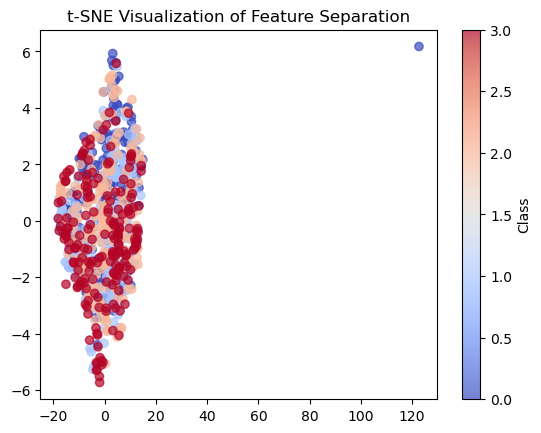

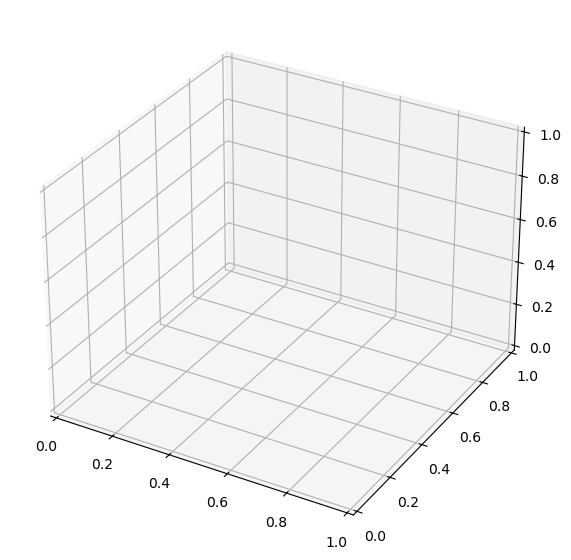

In [100]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne_model = TSNE(n_components=3, random_state=42, perplexity=50, learning_rate=200, max_iter=1000)
X_reduced_tsne = tsne_model.fit_transform(features)

plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=Y, cmap='coolwarm', alpha=0.7)
# plt.scatter(pitch_features[:, 0], pitch_features[:, 1], c=Y, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('t-SNE Visualization of Feature Separation')
plt.show()
#
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = Scatter3d(
    x=X_reduced_tsne[:, 0],
    y=X_reduced_tsne[:, 1],
    z=X_reduced_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=Y,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = Layout(
    title='3D Interactive Visualization of Feature Separation',
    scene=dict(
        xaxis_title='Feature 5',
        yaxis_title='Feature 4',
        zaxis_title='Feature 3'
    )
)

fig = Figure(data=[scatter], layout=layout)
fig.show()

plt.show()

In [93]:
unique_classes = np.unique(Y)
class_avg = np.zeros((len(unique_classes), 40))
i = 0
for cls in unique_classes:
    class_avg[i] = features[Y == cls].mean(axis=0)
    #print(f'Class {cls} Average t-SNE Coordinates: {class_avg}')
    i += 1
    
differences = np.zeros( 40)
for i in range(features.shape[1]):
    differences[i] = abs(class_avg[0][i] - class_avg[1][i])+abs(class_avg[0][i] - class_avg[2][i]) + abs(class_avg[0][i] - class_avg[3][i]) + abs(class_avg[1][i] - class_avg[2][i]) + abs(class_avg[1][i] - class_avg[3][i]) + abs(class_avg[2][i] - class_avg[3][i])

print(f'Class Average Differences: {differences}')

top_3_indices = np.argsort(differences)[-3:][::-1]
print(f'Top 3 Maximum Differences Indices: {top_3_indices}')
print(f'Top 3 Maximum Differences Values: {differences[top_3_indices]}')

Class Average Differences: [39.04840088 48.2635498   8.70092615 17.71121788 31.15101099 18.822788
 20.14734817 12.44897747  9.91927528  8.87717712 10.4329505  11.18310595
  8.20037675  3.52251577 11.72174859 20.96168509 11.00406909  9.54434636
  8.28626084  3.58520341  1.26940203  6.60472477  2.3790834   6.57824567
  2.04385304  5.29257293  7.3847307   5.88473691  9.25380799  9.62271222
 10.1111863   9.94755425 14.02699468 11.21991733 12.77088273  9.24213678
 11.45483109  8.62956846  8.07325006  6.78896087]
Top 3 Maximum Differences Indices: [1 0 4]
Top 3 Maximum Differences Values: [48.2635498  39.04840088 31.15101099]
